# Quick assessment on non-single-cell Mtb replication

In [45]:
import napari
from macrohet import dataio, tile, tools, animate
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [4]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = dataio.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


In [5]:
metadata

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [6]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True, mask_exist=False,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [7]:
row = '3'
column = '5'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [8]:
%%time
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane='sum_proj', 
                             set_channel = 2,
                             )#tile.compile_mosaic(image_dir, metadata, row, column,).compute().compute()
images

CPU times: user 183 ms, sys: 3.83 ms, total: 187 ms
Wall time: 184 ms


,Array,Chunk
Bytes,20.44 GiB,31.01 MiB
Shape,"(75, 1, 6048, 6048)","(1, 1, 2016, 2016)"
Count,9450 Tasks,675 Chunks
Type,uint64,numpy.ndarray


# Iterate over RFP images, measuring total RFP signal

In [10]:
rfp_df = pd.DataFrame({}, columns = assay_layout.index)


In [24]:
line

((6, 9),
 Strain               WT
 Compound            BDQ
 Concentration       2.5
 ConcentrationEC    EC99
 Name: (6, 9), dtype: object)

In [14]:
for line in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    print(line)

  0%|          | 0/24 [00:00<?, ?it/s]

((3, 4), Strain              RD1
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 4), dtype: object)
((3, 5), Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 5), dtype: object)
((3, 6), Strain               WT
Compound            PZA
Concentration        60
ConcentrationEC    EC50
Name: (3, 6), dtype: object)
((3, 7), Strain               WT
Compound            RIF
Concentration       0.1
ConcentrationEC    EC50
Name: (3, 7), dtype: object)
((3, 8), Strain               WT
Compound            INH
Concentration      0.04
ConcentrationEC    EC50
Name: (3, 8), dtype: object)
((3, 9), Strain               WT
Compound            BDQ
Concentration      0.02
ConcentrationEC    EC50
Name: (3, 9), dtype: object)
((4, 4), Strain              RD1
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (4, 4), dtype: object)
((4, 5), Strain               WT
Compound           CTRL
Conce

In [15]:
for i, line in tqdm(enumerate(assay_layout.iterrows()), total = len(assay_layout)):
        if i == 2:
            break
        strain = line[1]['Strain']
        compound = line[1]['Compound']
        conc = line[1]['Concentration']
        name = f'{strain, compound, conc}'
        row, column = line[0]

        images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane='sum_proj', 
                             set_channel = 2,
                             )
        rfp_signals = []
        for t in tqdm(range(0,len(images)), leave = False):
            try:
                frame = images[t].compute().compute()
                rfp_signal = np.sum(frame)
            except Exception as e:
                print(f'Could not load frame {t} row, col {line[0]}')
                print(e)
                rfp_signal = None
            rfp_signals.append(rfp_signal)
        rfp_df[line[0]] = rfp_signals
        rfp_df.to_csv('RFP_signals.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [20]:
rfp_df[(3,4)]

0     13380000033
1     13376183883
2     13380856349
3     13371439766
4     13372550286
         ...     
70    13631323270
71    13639562334
72    13626904003
73    13640313929
74    13648631253
Name: (3, 4), Length: 75, dtype: uint64

<AxesSubplot:ylabel='(3, 4)'>

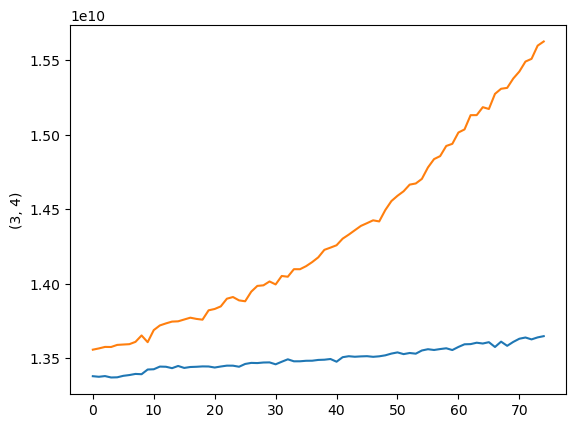

In [23]:
sns.lineplot(data = rfp_df[(3,4)])
sns.lineplot(data = rfp_df[(3,5)])

In [43]:
assay_layout.T[(3,4)]


Strain              RD1
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 4), dtype: object

In [58]:
palette = sns.color_palette('rocket')
palette

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

/tmp/ipykernel_799740/4042845872.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


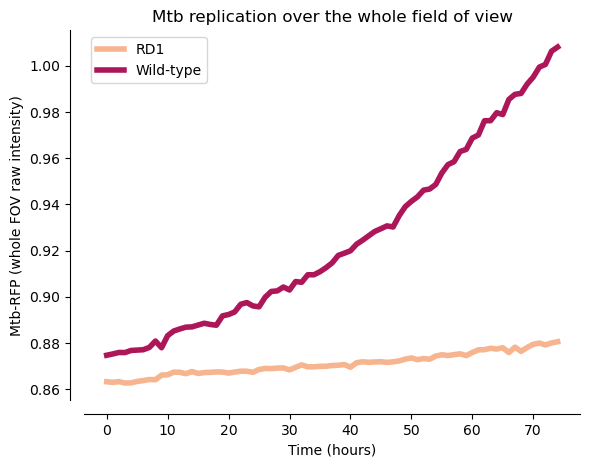

In [62]:
sns.lineplot(data = rfp_df[(3,4)]/1.55E10, label = 'RD1', linewidth = 4, color = palette[5]
#                       palette = 'rocket_r'
                  )
sns.lineplot(data = rfp_df[(3,5)]/1.55E10, label ='Wild-type', linewidth = 4, color = palette[2])
sns.despine(offset=10) # the important part here
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view')# (Replication_IPSDM_GFP dataset)')
fig.show()
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_mtb_growth/whole_fov_mtb_growth_row_WT_RD1.png', bbox_inches = 'tight', dpi = 314)

/tmp/ipykernel_799740/3633058285.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


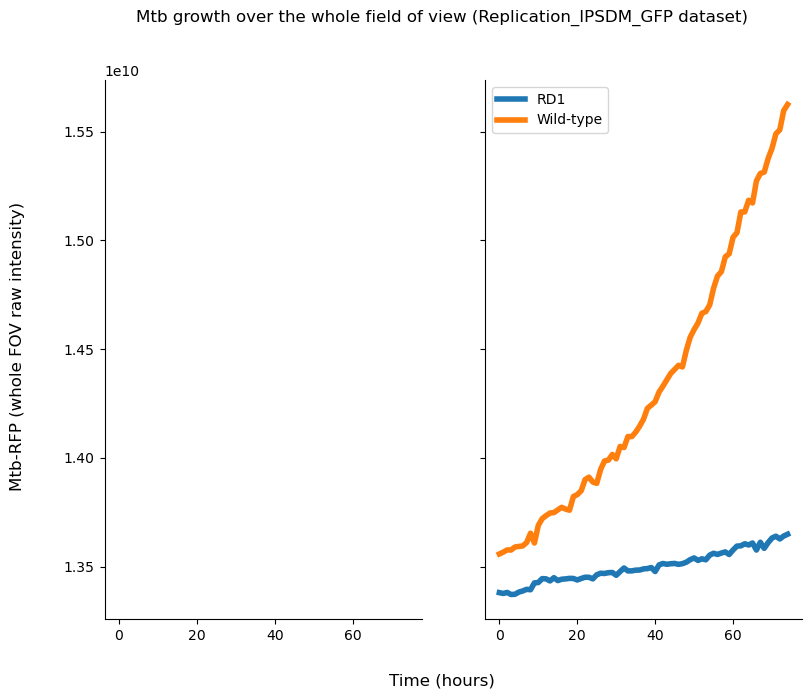

In [47]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, 
                      figsize = (9,7))
LHS = sns.lineplot(data = rfp_df[(3,4)], label = 'RD1', linewidth = 4,
#                       palette = 'rocket_r'
                  )
sns.despine(ax=ax[0], offset=0) 
    
LHS.set(ylabel = None)
sns.lineplot(data = rfp_df[(3,5)],ax=ax[1], label ='Wild-type', linewidth = 4)
sns.despine(ax=ax[1], offset=0) # the important part here
plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle('Mtb growth over the whole field of view (Replication_IPSDM_GFP dataset)')
fig.show()
# plt.savefig('/mnt/DATA/macrohet/results/whole_fov_mtb_growth/whole_fov_mtb_growth_row_WT_RD!.png', bbox_inches = 'tight', dpi = 314)

In [22]:
assay_layout

Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

In [114]:
import matplotlib.pyplot as plt

In [282]:
sns.set_theme(style="ticks")
sns.color_palette("rocket_r")

[(0.96516917, 0.70776351, 0.5606593),
 (0.95381595, 0.46373781, 0.31769923),
 (0.8833417, 0.19830556, 0.26014181),
 (0.67824099, 0.09192342, 0.3504148),
 (0.43860848, 0.12177004, 0.34119475),
 (0.20973515, 0.09747934, 0.24238489)]

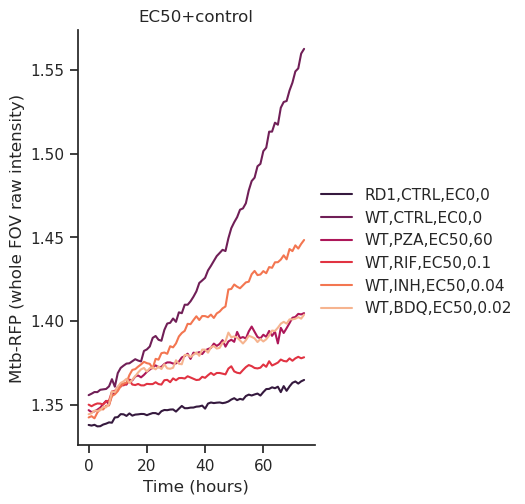

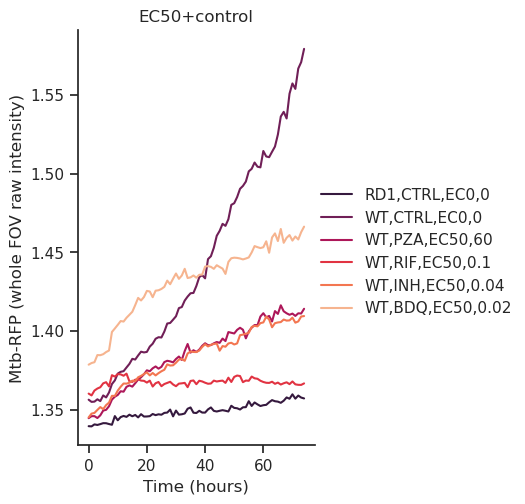

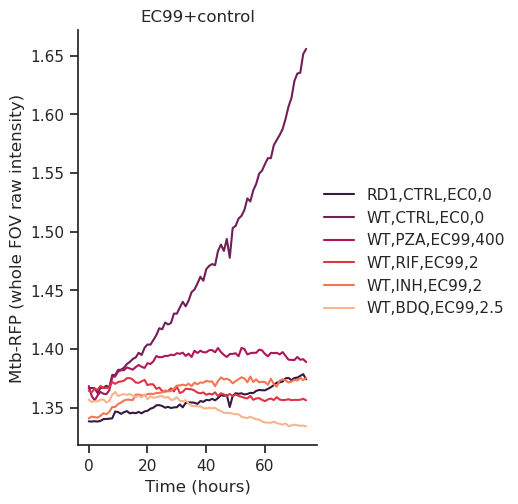

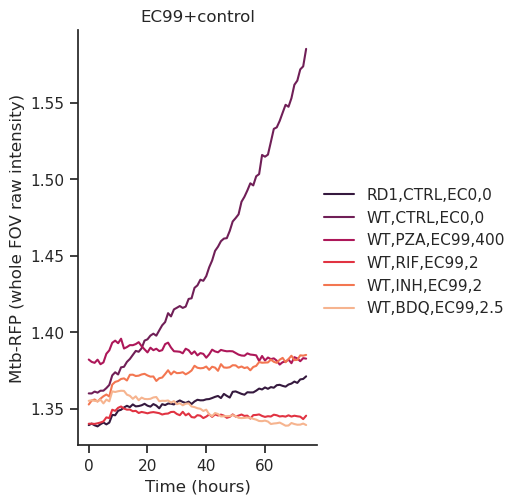

In [344]:
plots = dict()
plot_dfs = dict()
for n, (row, conc_EC_df) in enumerate((assay_layout.groupby(level=0))):
    max_vals = list()
    conc_grouped_df = pd.DataFrame()
    for row, column in conc_EC_df.index:
        info = conc_EC_df.loc[(row, column)]
        strain = info['Strain']
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        conc_grouped_df[label] = rfp_df[(row,column)]
    plot_dfs[n] = conc_grouped_df
    fig = sns.relplot(
        data=conc_grouped_df/1E10,
        kind="line", 
        palette=palette,
#         height=3, aspect=2, dashes=False
        height=5, aspect=0.75, dashes=False

    )
    plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.xlabel('Time (hours)')
    plt.title(ec_conc+ '+control')
    
    plots[(row,column)] = fig


In [329]:
sns.set_theme(style="ticks")
sns.set_palette("rocket_r")

In [346]:
for n, (row, conc_EC_df) in enumerate((assay_layout.groupby(level=0))):
    print(n, row, conc_EC_df)

0 3            Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
1 4            Strain Compound Concentration ConcentrationEC
Row Column                                              
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
2 5            Strain Compound Concentration ConcentrationEC
Row Column         

/tmp/ipykernel_272240/212528242.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


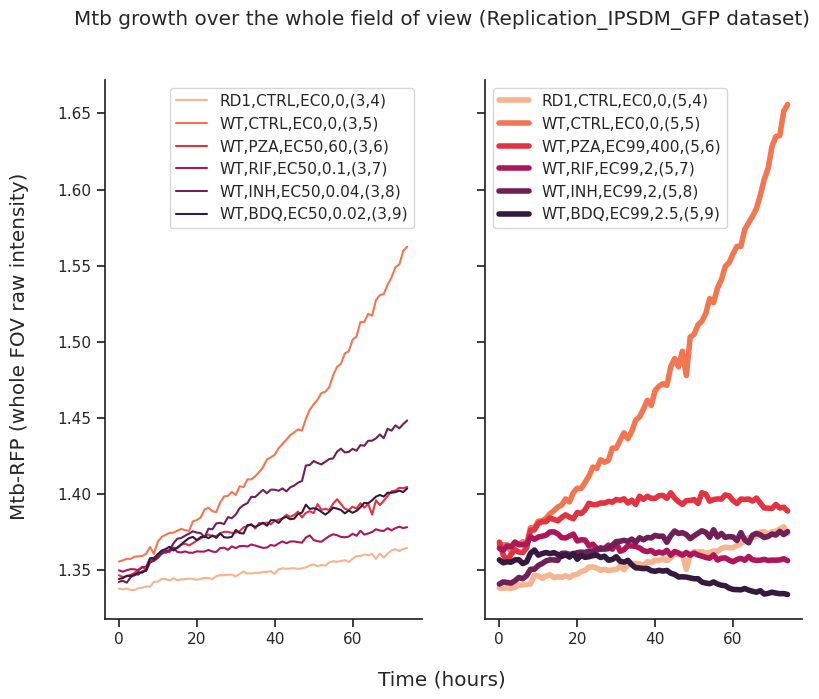

In [357]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, 
                      figsize = (9,7))
for n, i in enumerate(plot_dfs[0].items()):
    label = i[0] + f',(3,{n+4})'
    LHS = sns.lineplot(data = i[1]/1E10,ax=ax[0], label =label, linewidth = 4,
#                       palette = 'rocket_r'
                      )
    sns.despine(ax=ax[0], offset=0) 
    
LHS.set(ylabel = None)
for n, i in enumerate(plot_dfs[2].items()):
    label = i[0] + f',(5,{n+4})'
    sns.lineplot(data = i[1]/1E10,ax=ax[1], label =label, linewidth = 4)
    sns.despine(ax=ax[1], offset=0) # the important part here
plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle('Mtb growth over the whole field of view (Replication_IPSDM_GFP dataset)')
fig.show()
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_mtb_growth/whole_fov_mtb_growth_row3&5.png', bbox_inches = 'tight', dpi = 314)

/tmp/ipykernel_272240/2308218251.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


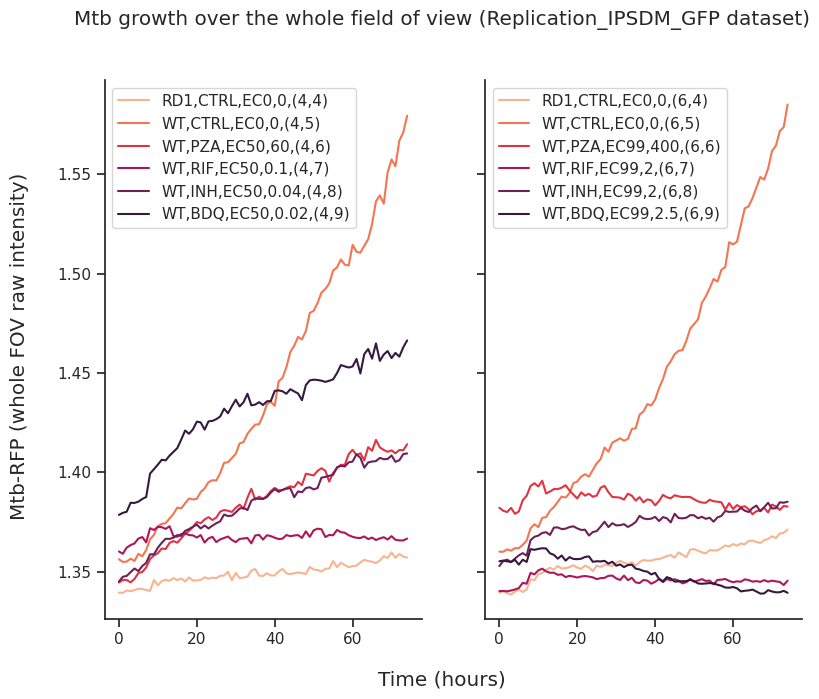

In [354]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, 
                      figsize = (9,7))
for n, i in enumerate(plot_dfs[1].items()):
    label = i[0] + f',(4,{n+4})'
    LHS = sns.lineplot(data = i[1]/1E10,ax=ax[0], label =label, 
#                       palette = 'rocket_r'
                      )
    sns.despine(ax=ax[0], offset=0) 
    
LHS.set(ylabel = None)
for n, i in enumerate(plot_dfs[3].items()):
    label = i[0] + f',(6,{n+4})'
    sns.lineplot(data = i[1]/1E10,ax=ax[1], label =label)
    sns.despine(ax=ax[1], offset=0) # the important part here
plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle('Mtb growth over the whole field of view (Replication_IPSDM_GFP dataset)')
fig.show()
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_mtb_growth/whole_fov_mtb_growth_row4&6.png', bbox_inches = 'tight', dpi = 314)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


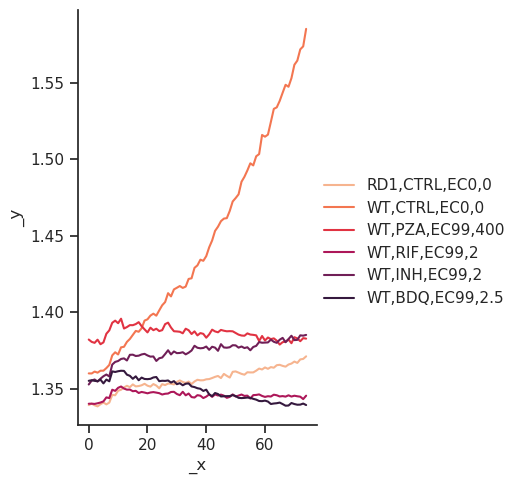

In [245]:
sns.relplot(ax=axes[0],
        data=conc_grouped_df/1E10,
        kind="line", 
        palette=palette,
#         height=3, aspect=2, dashes=False
        height=5, aspect=0.75, dashes=False
           )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


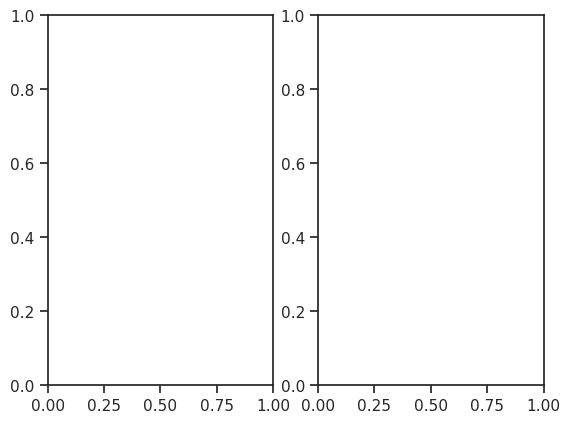

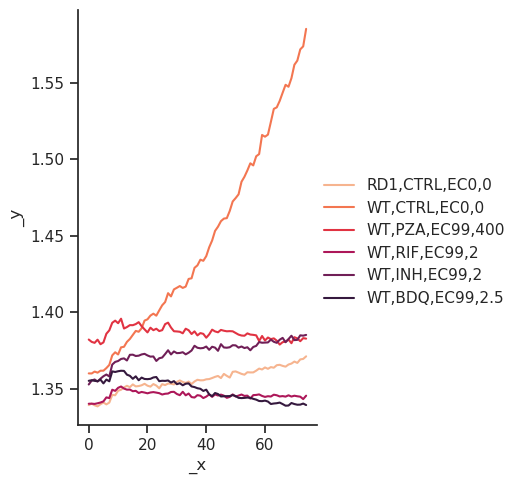

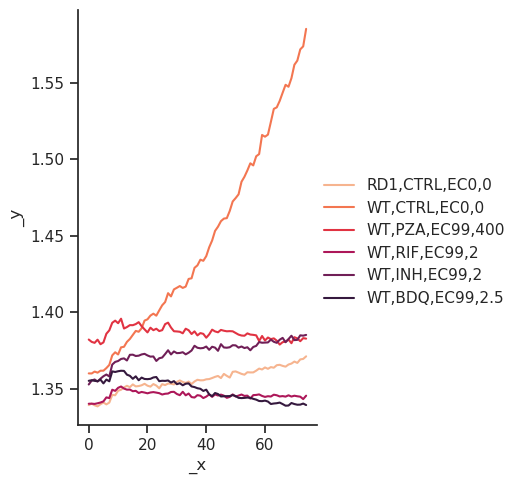

In [251]:
f, axes = plt.subplots(1, 2)
df = pd.DataFrame(dict(col1=np.linspace(1, 10, 5), col2=np.linspace(1, 10, 5)))
sns.relplot(
        data=conc_grouped_df/1E10,
        kind="line", 
        palette=palette,
#         height=3, aspect=2, dashes=False
        height=5, aspect=0.75, dashes=False,
ax = axes[0]
    )
sns.relplot(
        data=conc_grouped_df/1E10,
        kind="line", 
        palette=palette,
#         height=3, aspect=2, dashes=False
        height=5, aspect=0.75, dashes=False,
ax = axes[0]
    )
plt.show()

In [204]:
for i in plots:
    

{(3, 9): <seaborn.axisgrid.FacetGrid at 0x7f7dd4beabb0>,
 (4, 9): <seaborn.axisgrid.FacetGrid at 0x7f7dd4beac10>,
 (5, 9): <seaborn.axisgrid.FacetGrid at 0x7f7dd5129e80>,
 (6, 9): <seaborn.axisgrid.FacetGrid at 0x7f7dd4a7eeb0>}

In [223]:
plot_dfs

{0:     RD1,CTRL,EC0,0  WT,CTRL,EC0,0  WT,PZA,EC50,60  WT,RIF,EC50,0.1  \
 0      13380000033    13557907348     13468257625      13500991374   
 1      13376183883    13566411409     13456716966      13491827623   
 2      13380856349    13576426576     13461218054      13501614714   
 3      13371439766    13575952568     13471003397      13508312587   
 4      13372550286    13589888457     13483264883      13507266166   
 ..             ...            ...             ...              ...   
 70     13631323270    15423555571     14019956258      13763221021   
 71     13639562334    15490443584     14024465796      13777537454   
 72     13626904003    15508673201     14043029863      13786683150   
 73     13640313929    15597084551     14039722795      13777937117   
 74     13648631253    15625140547     14047609987      13784015842   
 
     WT,INH,EC50,0.04  WT,BDQ,EC50,0.02  
 0       1.342468e+10       13443771250  
 1       1.343215e+10       13449681438  
 2       1.341971

In [226]:
def plot(df):
    return sns.relplot(data=df/1E10,
                            kind="line", 
                            palette=palette,
                            height=5, aspect=0.75, dashes=False)

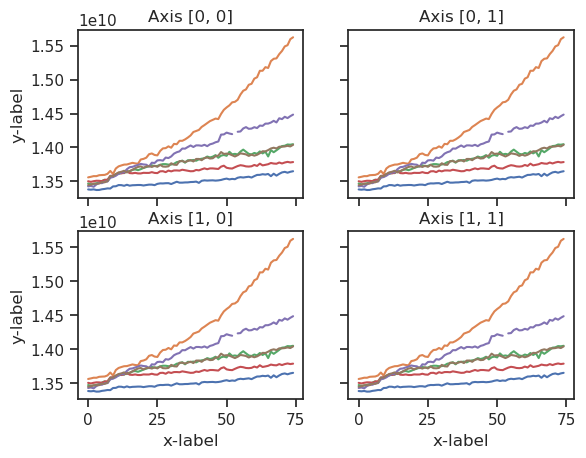

In [228]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(plot_dfs[0])
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(plot_dfs[0])
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(plot_dfs[0])
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(plot_dfs[0])
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Aligning x-axis using sharex')
ax1.plot(x, y)
ax2.plot(x + 1, -y)

In [189]:
plots

(3, 4)

In [ ]:
plots = assay_layout.index[0]

figs={}
axs={}
for idx,plot in (plots):
    figs[idx]=plt.figure()
    axs[idx]=figs[idx].add_subplot(111)
    axs[idx].plot(plot[0],plot[1])


In [185]:
assay_layout.index

MultiIndex([(3, 4),
            (3, 5),
            (3, 6),
            (3, 7),
            (3, 8),
            (3, 9),
            (4, 4),
            (4, 5),
            (4, 6),
            (4, 7),
            (4, 8),
            (4, 9),
            (5, 4),
            (5, 5),
            (5, 6),
            (5, 7),
            (5, 8),
            (5, 9),
            (6, 4),
            (6, 5),
            (6, 6),
            (6, 7),
            (6, 8),
            (6, 9)],
           names=['Row', 'Column'])

In [171]:
conc_grouped_df.max().max()

15625140547.0

In [172]:
conc_grouped_df/conc_grouped_df.max().max()

,"RD1,CTRL,EC0,0","WT,CTRL,EC0,0","WT,PZA,EC50,60","WT,RIF,EC50,0.1","WT,INH,EC50,0.04","WT,BDQ,EC50,0.02"
0,0.856312,0.867698,0.861961,0.864056,0.859172,0.860394
1,0.856068,0.868243,0.861222,0.863469,0.859650,0.860772
2,0.856367,0.868883,0.861510,0.864096,0.858854,0.861768
3,0.855764,0.868853,0.862136,0.864524,0.861041,0.861675
4,0.855836,0.869745,0.862921,0.864457,0.862459,0.861894
...,...,...,...,...,...,...
70,0.872397,0.987099,0.897269,0.880838,0.922725,0.896641
71,0.872924,0.991379,0.897558,0.881754,0.924930,0.896896
72,0.872114,0.992546,0.898746,0.882340,0.923687,0.897497
73,0.872972,0.998204,0.898534,0.881780,0.925484,0.896925


Text(0.5, 32.99999999999997, 'Time (hours)')

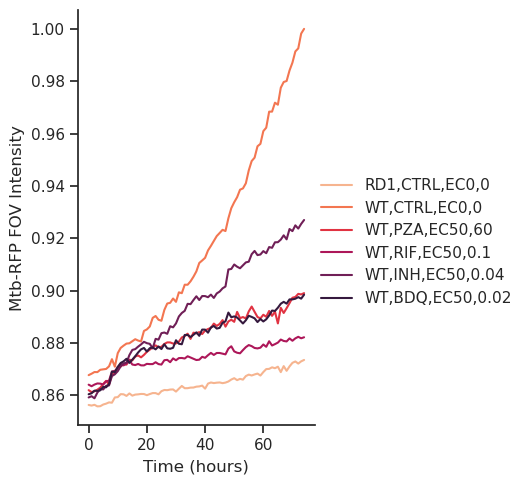

In [173]:
rescale_df = conc_grouped_df/conc_grouped_df.max().max()
sns.relplot(
    data=rescale_df,
    kind="line", 
    palette=palette,
    height=5, aspect=.75, dashes=False
)
plt.ylabel('Mtb-RFP FOV Intensity')
plt.xlabel('Time (hours)')

Text(0.5, 32.99999999999997, 'Time (hours)')

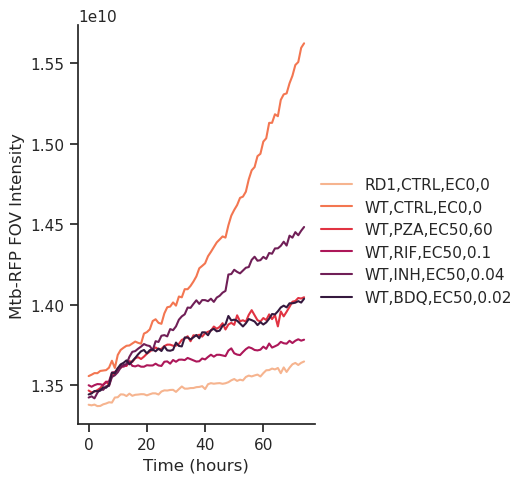

In [176]:

sns.relplot(
    data=conc_grouped_df,
    kind="line", 
    palette=palette,
    height=5, aspect=.75, dashes=False
)
plt.ylabel('Mtb-RFP FOV Intensity')
plt.xlabel('Time (hours)')

Text(0.5, 0, 'Time (hours)')

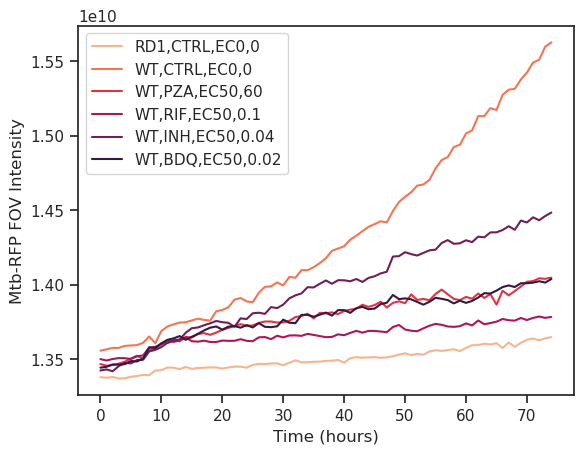

In [161]:
sns.lineplot(
    data=conc_grouped_df,
#     kind="line", 
    palette=palette,
#     height=5, 
#     aspect=.75,
    dashes=False
)
plt.ylabel('Mtb-RFP FOV Intensity')
plt.xlabel('Time (hours)')

In [120]:
max_val

15625140547.0

In [96]:
info = conc_EC_df.loc[(row, column)]

In [99]:
info

Strain              RD1
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 4), dtype: object

In [98]:
info['Strain']

'RD1'

In [111]:
label

'RD1,CTRL,EC0,0'

In [106]:
strain+comp+conc

'RD1CTRLEC0'

In [105]:
label

"('RD1', 'CTRL', 'EC0')"

In [84]:
conc_EC_df

Strain Compound Concentration ConcentrationEC
Row Column                                              
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [86]:
conc_EC_df

Strain Compound Concentration ConcentrationEC
Row Column                                              
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

TypeError: 'NoneType' object is not iterable

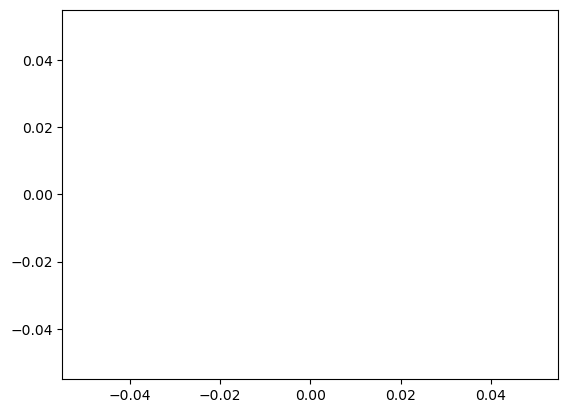

In [85]:
sns.lineplot(data = conc_EC_df)

In [82]:
test

0     13394455608
1     13404279701
2     13393404532
3     13386247513
4     13400366814
         ...     
70    13678776877
71    13670038169
72    13692837381
73    13696030324
74    13712853964
Name: (6, 4), Length: 75, dtype: uint64

In [70]:
row

6

In [76]:
concEC_df.index

MultiIndex([(6, 4),
            (6, 5),
            (6, 6),
            (6, 7),
            (6, 8),
            (6, 9)],
           names=['Row', 'Column'])

In [72]:
concEC_df.loc[(6,4)]

Strain              RD1
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (6, 4), dtype: object

In [60]:
concEC_df[0]

6

In [50]:
for col in row:
    print(col[0])

6
           Strain Compound Concentration ConcentrationEC
Row Column                                              
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99


pandas.core.frame.DataFrame

In [39]:
for i in assay_layout.index:
    print(i)

(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)


In [ ]:
for concEC in assay

In [ ]:
import sys
sys.path.append('../macrohet/')
from notify import send_sms
send_sms('RFP measurements complete')

# Checking view

In [11]:
images = tile.compile_mosaic(image_dir, 
                                     metadata, 
                                     row, column,
                                     set_plane='sum_proj')
viewer = napari.Viewer()
viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green", "magenta"],# "magenta"],
                 contrast_limits=[[100, 6000], [0, 3000]], 
#                  scale=microns_per_pixel
                 )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer 'macrophage' at 0x7fe37a446280>,
 <Image layer 'mtb' at 0x7fe32c1e04f0>]

#### Iterate over all positions and create animations

In [44]:
from napari_animation import Animation
from tqdm.auto import tqdm
import os

In [ ]:
for plane in [2,3, 'sum_proj']:
    for row in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
        strain = row[1]['Strain']
        compound = row[1]['Compound']
        conc = row[1]['Concentration']
        name = f'{strain, compound, conc}'
        row, column = row[0]

        fn = f'/home/dayn/Videos/tb_mp4s/tiling/z={plane}/{row,column,strain,compound,conc}[row,col,strain,compound,conc.].mp4'
#         if fn...
        
        images = tile.compile_mosaic(image_dir, 
                                     metadata, 
                                     row, column,
                                     set_plane=plane)
        images = images.compute().compute()
        
        if plane == 'sum_proj':
            contrast_limits = [[100, 6000], [0, 3000]]
        else:
            contrast_limits = [[100, 2000], [0, 1000]]
        
        viewer = napari.Viewer()
        viewer.add_image(images, 
                         channel_axis=1,
                         name=["macrophage", "mtb"],
                         colormap=["green", "magenta"],# "magenta"],
                         contrast_limits=contrast_limits, 
                         scale=microns_per_pixel
                         )
        
        viewer.scale_bar.visible = True
        viewer.scale_bar.unit = 'm'
        viewer.scale_bar.font_size = text_size
        viewer.text_overlay.visible = True
        viewer.text_overlay.color = 'white'
        viewer.text_overlay.position = 'bottom_left'
        viewer.text_overlay.font_size = text_size
        viewer.dims.events.current_step.connect(update_slider)

        animation = Animation(viewer)
        viewer.update_console({'animation': animation})
        # viewer.camera.center = (0, 0, 3024, 3024)
        viewer.dims.current_step = (0.0, 0.00045199517018090773, 0.00045199517018090773)
        viewer.camera.zoom = 718694.1391941392
        animation.capture_keyframe(steps = 100)
        viewer.dims.current_step = (74, 0, 0, 0)
        animation.capture_keyframe(steps = 100)

        animation.animate(fn, 
                          canvas_only=True,
                          fps = 7,
                          quality = 9)
        viewer.close()


  0%|          | 0/24 [00:00<?, ?it/s]

In [167]:
viewer = napari.Viewer()
viewer.add_image(images, 
             channel_axis=1,
             name=[f"macrophage {name}", "mtb"],
             colormap=["green", "magenta"],
             contrast_limits=[[100, 2000], [100, 500]]
             )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer "macrophage ('WT', 'CTRL', '0')" at 0x7fa29cc5a400>,
 <Image layer 'mtb' at 0x7fa29cafd760>]

In [47]:
viewer.camera

Camera(center=(0.0, 2951.859350744619, 3219.9900080799753), zoom=0.10979662698412698, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True)

In [6]:
for row in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    strain = row[1]['Strain']
    compound = row[1]['Compound']
    conc = row[1]['Concentration']
    name = f'{strain, compound, conc}'
    
    row, column = row[0]
    images = tile.compile_mosaic(image_dir, metadata, row, column,set_plane=1)
    
    viewer = napari.Viewer()
    viewer.add_image(images, 
                 channel_axis=1,
                 name=[f"macrophage {name}", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
    
    animation = Animation(viewer)
    viewer.update_console({'animation': animation})
    viewer.camera.center = (0, 0, 3024, 3024)
    viewer.dims.current_step = (0, 0, 0, 0)
    viewer.camera.zoom = 0.109
    animation.capture_keyframe(steps = 100)
    viewer.dims.current_step = (74, 0, 0, 0)
    animation.capture_keyframe(steps = 100)
    fn = f'/home/dayn/Videos/tb_mp4s/tiling/tiling{row,column,strain,compound,conc}.mp4'
    animation.animate(fn, 
                      canvas_only=True,
                      fps = 7,
                      quality = 9)
    
    

  0%|          | 0/24 [00:00<?, ?it/s]

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 17:39:17 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<02:09,  1.29s/it][swscaler @ 0x654dec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:51<00:00,  5.86s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 17:49:36 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:18,  1.28it/s][swscaler @ 0x7312ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:47<00:00,  5.82s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 17:59:49 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:16,  1.31it/s][swscaler @ 0x590fec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:40<00:00,  5.75s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 18:09:57 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:15,  1.33it/s][swscaler @ 0x6acfec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:32<00:00,  5.67s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 18:19:58 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:15,  1.32it/s][swscaler @ 0x59a3ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:28<00:00,  5.63s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 18:29:55 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:21,  1.23it/s][swscaler @ 0x6f8bec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:37<00:00,  5.72s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 18:40:01 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:12,  1.37it/s][swscaler @ 0x5fe6ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:39<00:00,  5.74s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 18:50:09 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:13,  1.36it/s][swscaler @ 0x5729ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:38<00:00,  5.73s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 19:00:16 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:22,  1.21it/s][swscaler @ 0x66a1ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:27<00:00,  5.62s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 19:10:12 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:25,  1.17it/s][swscaler @ 0x6128ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:42<00:00,  5.77s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 19:20:23 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:18,  1.27it/s][swscaler @ 0x57d9ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:34<00:00,  5.69s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 19:30:26 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:26,  1.16it/s][swscaler @ 0x6f3eec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:42<00:00,  5.76s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 19:40:37 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:24,  1.19it/s][swscaler @ 0x64f8ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:40<00:00,  5.75s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 19:50:46 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:16,  1.31it/s][swscaler @ 0x643cec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:38<00:00,  5.73s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 20:00:52 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:21,  1.23it/s][swscaler @ 0x6205ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:38<00:00,  5.72s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 20:10:57 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:26,  1.16it/s][swscaler @ 0x55d3ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:34<00:00,  5.68s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 20:21:01 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:31,  1.10it/s][swscaler @ 0x6c5fec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:44<00:00,  5.79s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 20:31:15 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:32,  1.08it/s][swscaler @ 0x6995ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:35<00:00,  5.70s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 20:41:18 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:21,  1.23it/s][swscaler @ 0x6e13ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:38<00:00,  5.72s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 20:51:24 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:27,  1.15it/s][swscaler @ 0x6169ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:42<00:00,  5.77s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 21:01:36 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:21,  1.23it/s][swscaler @ 0x568bec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:33<00:00,  5.67s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 21:11:38 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:28,  1.13it/s][swscaler @ 0x6f6aec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:30<00:00,  5.65s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 21:21:36 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:36,  1.04it/s][swscaler @ 0x5759ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:46<00:00,  5.80s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 21:31:50 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:29,  1.12it/s][swscaler @ 0x5e84ec0] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:39<00:00,  5.74s/it]


In [7]:
for row in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    strain = row[1]['Strain']
    compound = row[1]['Compound']
    conc = row[1]['Concentration']
    name = f'{strain, compound, conc}'
    
    row, column = row[0]
    images = tile.compile_mosaic(image_dir, metadata, row, column,set_plane=1)
    
    viewer = napari.Viewer()
    viewer.add_image(images, 
                 channel_axis=1,
                 name=[f"macrophage {name}", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
    
    animation = Animation(viewer)
    viewer.update_console({'animation': animation})
    viewer.camera.center = (0, 0, 3024, 3024)
    viewer.dims.current_step = (0, 0, 0, 0)
    viewer.camera.zoom = 0.109
    animation.capture_keyframe(steps = 100)
    viewer.dims.current_step = (74, 0, 0, 0)
    animation.capture_keyframe(steps = 100)
    fn = f'/home/dayn/Videos/tb_mp4s/tiling/tiling_slower_{row,column,strain,compound,conc}.mp4'
    animation.animate(fn, 
                      canvas_only=True,
                      fps = 14,
                      quality = 9)

  0%|          | 0/24 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 21:41:58 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:33,  1.07it/s][swscaler @ 0x6a77100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:38<00:00,  5.73s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 21:52:05 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:30,  1.11it/s][swscaler @ 0x7127100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:45<00:00,  5.79s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 22:02:19 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:27,  1.15it/s][swscaler @ 0x5d40100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:46<00:00,  5.80s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 22:12:35 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:37,  1.03it/s][swscaler @ 0x63f7100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:41<00:00,  5.76s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 22:22:44 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:30,  1.10it/s][swscaler @ 0x5ffa100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:34<00:00,  5.69s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 22:32:50 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:26,  1.15it/s][swscaler @ 0x6ba8100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:42<00:00,  5.77s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 22:43:01 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:37,  1.02it/s][swscaler @ 0x710b100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:49<00:00,  5.84s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 22:53:19 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:37,  1.03it/s][swscaler @ 0x5768100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:49<00:00,  5.84s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 23:03:38 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:48,  1.09s/it][swscaler @ 0x6bec100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:46<00:00,  5.80s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 23:13:50 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:38,  1.01it/s][swscaler @ 0x66d0100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:44<00:00,  5.79s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 23:24:02 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:46,  1.06s/it][swscaler @ 0x635d100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:45<00:00,  5.80s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 23:34:16 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:44,  1.05s/it][swscaler @ 0x64b3100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:51<00:00,  5.85s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 23:44:35 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:45,  1.06s/it][swscaler @ 0x6495100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:39<00:00,  5.74s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]13-Jan-23 23:54:44 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:48,  1.09s/it][swscaler @ 0x7035100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:32<00:00,  5.66s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 00:04:43 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:30,  1.11it/s][swscaler @ 0x6ee5100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:54<00:00,  5.88s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 00:15:05 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:00<01:38,  1.02it/s][swscaler @ 0x5d29100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:56<00:00,  5.91s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 00:25:32 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:51,  1.12s/it][swscaler @ 0x6f9d100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:44<00:00,  5.79s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 00:35:46 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:48,  1.08s/it][swscaler @ 0x585b100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:40<00:00,  5.74s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 00:45:51 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:01<01:41,  1.01s/it][swscaler @ 0x5c0b100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:44<00:00,  5.79s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 00:56:19 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:08<14:37,  8.77s/it][swscaler @ 0x6aba100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:52<00:00,  5.87s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 01:06:45 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:07<13:12,  7.92s/it][swscaler @ 0x5922100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:43<00:00,  5.78s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 01:17:04 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:07<12:49,  7.69s/it][swscaler @ 0x5da2100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:59<00:00,  5.93s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 01:27:40 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:08<13:38,  8.19s/it][swscaler @ 0x5af5100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:53<00:00,  5.87s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]14-Jan-23 01:38:07 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 699) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:07<12:53,  7.74s/it][swscaler @ 0x66b6100] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:54<00:00,  5.88s/it]


In [ ]:
for row in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    strain = row[1]['Strain']
    compound = row[1]['Compound']
    conc = row[1]['Concentration']
    name = f'{strain, compound, conc}'
    
    row, column = row[0]
    images = tile.compile_mosaic(image_dir, metadata, row, column,set_plane=1)
    
    viewer = napari.Viewer()
    viewer.add_image(images, 
                 channel_axis=1,
                 name=[f"macrophage {name}", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
                    
    animation = Animation(viewer)
    viewer.update_console({'animation': animation})
    viewer.camera.center = (0, 0, 3122, 2976)
    viewer.dims.current_step = (0, 0, 0, 0)
    viewer.camera.zoom = 0.4169
    animation.capture_keyframe(steps = 100)
    viewer.dims.current_step = (74, 0, 0, 0)
    animation.capture_keyframe(steps = 100)
    fn = f'/home/dayn/Videos/tb_mp4s/tiling/zoom_center_tiling{row,column,strain,compound,conc}.avi'
    animation.animate(fn, 
                      canvas_only=True,
                      fps = 7,
                      quality = 9)

  0%|          | 0/24 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]16-Jan-23 09:46:03 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 700) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:07<12:19,  7.40s/it][swscaler @ 0x5ea7f80] Warning: data is not aligned! This can lead to a speed loss

100%|████████████████████████████████████████████████████████████████| 101/101 [09:41<00:00,  5.76s/it]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" 

Rendering frames...



  0%|                                                                          | 0/101 [00:00<?, ?it/s]16-Jan-23 09:56:20 - imageio_ffmpeg - WARNING  - IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1123, 700) to (1136, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

  1%|▋                                                                 | 1/101 [00:08<13:54,  8.35s/it][swscaler @ 0x59d0f80] Warning: data is not aligned! This can lead to a speed loss

 33%|█████████████████████▏                                           | 33/101 [03:10<06:08,  5.41s/it]

# Tests

In [ ]:
viewer = napari.Viewer()
    viewer.add_image(images, 
                 channel_axis=1,
                 name=[f"macrophage {name}", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
    
    animation = Animation(viewer)
    viewer.update_console({'animation': animation})
    viewer.camera.center = (0, 0, 3024, 3024)
    viewer.dims.current_step = (0, 0, 0, 0)
    viewer.camera.zoom=0.13535
    animation.capture_keyframe(steps = 100)
    viewer.dims.current_step = (74, 0, 0, 0)
    animation.capture_keyframe(steps = 100)
    fn = f'/home/dayn/Videos/tb_mp4s/tiling/tiling_slight_zoom_{row,column,strain,compound,conc}.mp4'
    animation.animate(fn, 
                      canvas_only=True,
                      fps = 7,
                      quality = 9)
    
    viewer = napari.Viewer()
    viewer.add_image(images, 
                 channel_axis=1,
                 name=[f"macrophage {name}", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
    
    animation = Animation(viewer)
    viewer.update_console({'animation': animation})
    viewer.camera.center = (0, 0, 2164, 3994)
    viewer.dims.current_step = (0, 0, 0, 0)
    viewer.camera.zoom = 0.962
    animation.capture_keyframe(steps = 100)
    viewer.dims.current_step = (74, 0, 0, 0)
    animation.capture_keyframe(steps = 100)
    fn = f'/home/dayn/Videos/tb_mp4s/tiling/zoom_right_tiling{row,column,strain,compound,conc}.mp4'
    animation.animate(fn, 
                      canvas_only=True,
                      fps = 7,
                      quality = 9)

    viewer = napari.Viewer()
    viewer.add_image(images, 
                 channel_axis=1,
                 name=[f"macrophage {name}", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
    
    animation = Animation(viewer)
    viewer.update_console({'animation': animation})
    viewer.camera.center = (0, 0, 3122, 2976)
    viewer.dims.current_step = (0, 0, 0, 0)
    viewer.camera.zoom = 0.4169
    animation.capture_keyframe(steps = 100)
    viewer.dims.current_step = (74, 0, 0, 0)
    animation.capture_keyframe(steps = 100)
    fn = f'/home/dayn/Videos/tb_mp4s/tiling/zoom_center_tiling{row,column,strain,compound,conc}.mp4'
    animation.animate(fn, 
                      canvas_only=True,
                      fps = 7,
                      quality = 9)

In [35]:
viewer = napari.Viewer()
viewer.add_image(images, 
             channel_axis=1,
             name=[f"macrophage {name}", "mtb"],
             colormap=["green", "magenta"],
             contrast_limits=[[100, 2000], [100, 500]]
             )

animation = Animation(viewer)
viewer.update_console({'animation': animation})
viewer.camera.center = (0, 0, 3024, 3024)
viewer.camera.zoom = 0.18
animation.capture_keyframe(steps = 100)
viewer.dims.current_step = (74, 0, 0, 0)
animation.capture_keyframe(steps = 100)
fn = f'/home/dayn/Videos/tb_mp4s/tiling/tiling{row,column,strain,compound,conc}.mp4'
animation.animate(fn, 
                  canvas_only=True,
                     fps = 7,
                     quality = 9)

animation = Animation(viewer)
viewer.update_console({'animation': animation})
viewer.camera.center = (0, 0, 2164, 3994)
viewer.camera.zoom = 0.962
animation.capture_keyframe(steps = 100)
viewer.dims.current_step = (74, 0, 0, 0)
animation.capture_keyframe(steps = 100)
fn = f'/home/dayn/Videos/tb_mp4s/tiling/zoom_tiling{row,column,strain,compound,conc}.mp4'
animation.animate(fn, 
                  canvas_only=True,
                     fps = 7,
                     quality = 9)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Rendering frames...


100%|████████████████████████████████████████████████████████████████| 101/101 [04:46<00:00,  2.83s/it]


In [50]:
viewer = napari.Viewer()
viewer.add_image(images, 
             channel_axis=1,
             name=[f"macrophage {name}", "mtb"],
             colormap=["green", "magenta"],
             contrast_limits=[[100, 2000], [100, 500]]
             )

# animation = Animation(viewer)
# viewer.update_console({'animation': animation})
# viewer.camera.center = (0, 0, 3024, 3024)
# viewer.camera.zoom = 0.5
# animation.capture_keyframe(steps = 10)
# viewer.dims.current_step = (10, 0, 0, 0)
# animation.capture_keyframe(steps = 10)
# fn = f'/home/dayn/Videos/tb_mp4s/tiling/tiling{row,column,strain,compound,conc}.mp4'
# animation.animate(fn, 
#                   canvas_only=True,
#                      fps = 7,
#                      quality = 9)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer "macrophage ('WT', 'CTRL', '0')" at 0x7fd50f86c040>,
 <Image layer 'mtb' at 0x7fd519c9d850>]

In [52]:
viewer.camera

Camera(center=(0.0, 2964.168687360873, 2992.54454118942), zoom=0.13535462972612866, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True)